In [1]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
import matplotlib

from numba import njit, prange

In [2]:
dt = .001
tau = .1
w11, w12 = 1, 1
w21, w22 = 1, 1
noise_tau = .002
dur = 10
bifurcate_time = .8
threshold = 70
S = 576
R_initial = 32
sgm = 10
eta = S*.1

In [10]:
@njit(parallel=True, fastmath=True)
def ave_choice(coh, a, b):

    nan_num = 0
    alpha = a
    beta = 0

    R1_arr = np.zeros(int(dur/dt))
    R2_arr = np.zeros(int(dur/dt))
    # R1_arr[0], R2_arr[0] = R_initial, R_initial
    R1_arr[0] = ((alpha+beta-1) + np.sqrt((1-alpha-beta)**2 + 4*S*(w11+w12-1))) / (2*(w11+w12-1))
    R2_arr[0] = ((alpha+beta-1) + np.sqrt((1-alpha-beta)**2 + 4*S*(w22+w21-1))) / (2*(w22+w21-1))

    G1_arr = np.zeros(int(dur/dt))
    G2_arr = np.zeros(int(dur/dt))
    G1_arr[0], G2_arr[0] = (w11+w12-beta)*R1_arr[0], (w22+w21-beta)*R2_arr[0]

    D1_arr = np.zeros(int(dur/dt))
    D2_arr = np.zeros(int(dur/dt))
    D1_arr[0], D2_arr[0] = beta*R1_arr[0], beta*R2_arr[0]

    noise_R1 = np.zeros(int(dur/dt))
    noise_R2 = np.zeros(int(dur/dt))
    noise_G1 = np.zeros(int(dur/dt))
    noise_G2 = np.zeros(int(dur/dt))
    noise_D1 = np.zeros(int(dur/dt))
    noise_D2 = np.zeros(int(dur/dt))

    reaction_time = np.zeros(5000)
    choice = np.zeros(5000)

    for i in prange(5000):

        beta = 0
        V1, V2 = S, S

        for ti in range(1, int(dur/dt)):

            if ti == bifurcate_time/dt:
                beta = b

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                V1 = S*(1+coh) + np.random.randn() * eta
                V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta + .5*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta + .5*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
                choice[i] = 1
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN
                nan_num += 1

    return reaction_time, choice

In [11]:
def get_RT_choice(a, b):
    RT, choice = np.zeros(500), np.zeros(500)
    for coh in range(500):
        cur_RT, cur_choice = ave_choice(coh / 1000, a, b)
        RT[coh], choice[coh] = np.nanmean(cur_RT)*dt, np.nanmean(cur_choice)
        print("\r[EPOCH]: %d" % coh, end='')
    print("\r", end='')
    return RT, choice

In [12]:
RT1, choice1 = get_RT_choice(25, 0)
RT2, choice2 = get_RT_choice(25, 8)
RT3, choice3 = get_RT_choice(25, 16)
RT4, choice4 = get_RT_choice(25, 24)
RT5, choice5 = get_RT_choice(25, 32)
RT6, choice6 = get_RT_choice(25, 40)


KeyboardInterrupt



In [6]:
def draw_RT_choice(choice, RT, b, choice_ax, RT_ax, color):
    RT_ax.plot(RT, label="beta = %d" % b, color=color)
    choice_ax.plot(choice, label="beta = %d" % b, color=color)

In [2]:
parameters = np.linspace(0, 40, 7)
norm = matplotlib.colors.Normalize(vmin=np.min(parameters), vmax=np.max(parameters))

c_m = matplotlib.cm.BuPu
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)

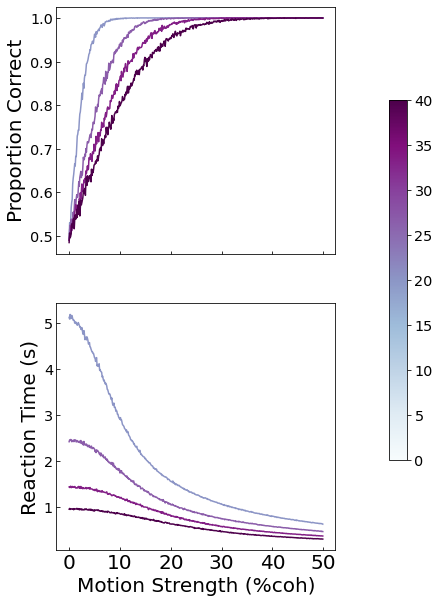

In [9]:
fig, (choice_ax, RT_ax) = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

draw_RT_choice(choice3, RT3, 16, choice_ax, RT_ax, s_m.to_rgba(parameters[3]))
draw_RT_choice(choice4, RT4, 24, choice_ax, RT_ax, s_m.to_rgba(parameters[4]))
draw_RT_choice(choice5, RT5, 32, choice_ax, RT_ax, s_m.to_rgba(parameters[5]))
draw_RT_choice(choice6, RT6, 40, choice_ax, RT_ax, s_m.to_rgba(parameters[6]))

choice_ax.set_ylabel("Proportion Correct")
RT_ax.set_ylabel("Reaction Time (s)")

RT_ax.set_xlabel("Motion Strength (%coh)")
RT_ax.xaxis.set_ticks(np.arange(0, 600, 100))
RT_ax.xaxis.set_ticklabels(np.arange(0, 60, 10))

RT_ax.grid(False)
RT_ax.tick_params(axis='x', direction="in")
RT_ax.tick_params(axis="y", direction="in")
RT_ax.tick_params(bottom=True, left=True)
RT_ax.spines['bottom'].set_color('0')
RT_ax.spines['left'].set_color('0')
RT_ax.patch.set_facecolor('white')

choice_ax.grid(False)
choice_ax.tick_params(axis='x', direction="in")
choice_ax.tick_params(axis="y", direction="in")
choice_ax.tick_params(bottom=True, left=True)
choice_ax.spines['bottom'].set_color('0')
choice_ax.spines['left'].set_color('0')
choice_ax.patch.set_facecolor('white')

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 20,
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

cbar_ax = fig.add_axes([1.05, 0.25, 0.05, 0.5])
fig.colorbar(s_m, cax=cbar_ax)

plt.savefig("additive_beta.eps", format="eps", bbox_inches='tight')
plt.savefig("additive_beta.tiff", format="tiff", bbox_inches='tight')